# Preprocess only


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys

Mounted at /content/drive


In [ ]:
#imports
print("Starting imports")
#basics
import time
print("Starting timer.")
startTime = time.time()

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

#cleaning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

print("Imports Complete")

Starting imports
Starting timer.
Imports Complete


## Get Data

In [ ]:
#paths
mainPath = '/content/drive/MyDrive/Data_derivedVelocity/'
data_full_ = mainPath + 'data_full_vMag.csv'
data_1201_ = mainPath + 'd1201_vMag.csv'

In [ ]:
#read data in
print("Reading Data In_")
df_all = pd.read_csv(data_full_)

df1201 = pd.read_csv(data_1201_)
print("Data read in completed.")

Reading Data In_
Data read in completed.


## Create functions from Homayra

In [ ]:
print("Establishing RMSPE functions.")

Establishing RMSPE functions.


In [ ]:
def rmspe(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square(((y_true - y_pred) / y_true))))*100

In [ ]:
def rmspe_1(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square(y_true - y_pred) / y_true))*100

In [ ]:
print("Function established.")

Function established.


## Clean Data/Prepare Data

In [ ]:
print("Begin data cleaning.")

df1201 = df1201.drop(columns = ['Unnamed: 0.1'])
df_all = df_all.drop(columns = ['Unnamed: 0.1'])

#1201 drop location variables
df1201_feats = df1201.drop(columns = ['surf_x', 'surf_y'])

#df_all drop location variables
df_all_feats_target = df_all.drop(columns = ['surf_x', 'surf_y', 'track_bed_x', 'track_bed_y'])

#1201 order to align with df_all
df1201_feats_ordered = df1201_feats[['surf_vx', 'surf_vy', 'surf_elv', 'surf_dhdt', 'surf_SMB', 'v_mag']]

#set the feature variables to our independent characteristic variables
feature_cols = ['surf_vx', 'surf_vy', 'surf_elv', 'surf_dhdt', 'surf_SMB','v_mag']

#split into X and Y
X_given = df_all_feats_target[feature_cols]
Y_given = df_all_feats_target['track_bed_target']

#combine all known X and validation 1201 X for standardizing
X_all = np.concatenate((X_given, df1201_feats_ordered))
#make y into a dataframe to be standardized
Y_all = pd.DataFrame(Y_given)

print("Data cleaned.\nScaling beginning.")

#standardize
#Not setting feature range, let it be automatically determined
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_all_std = scaler_X.fit_transform(X_all)
Y_all_std = scaler_Y.fit_transform(Y_all)

#can alternatively use the MinMaxScaler
print("Scaling Complete.\nSplitting Data Beginning.")

#split of 1201 data from X_all_std
X_non1201 = X_all_std[0:632706,:]
X_1201_data = X_all_std[632706:, :]

# #generate a randomseed for training and testing split
# generated = np.random.randint(0,1000,1)[0]
# print(f"Generated random split for train-test: {generated}")
generated = 168

#set the train-test split
#60-40 showed the most promising from previous research and additional testing
train_size_ = .6
#split training and test from df_all
x_train, x_test, y_train, y_test = train_test_split(X_non1201, Y_all_std, train_size = train_size_, test_size = 1-train_size_, random_state = generated)

#get validation data
val_split = .2 #can change as needed
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = 1-val_split, test_size = val_split, random_state = generated)

print(f"Data train-split complete with: {train_size_ * 100}% training, {(1- train_size_) * 100}% testing, {val_split*100}% validation")

Begin data cleaning.
Data cleaned.
Scaling beginning.
Scaling Complete.
Splitting Data Beginning.
Data train-split complete with: 60.0% training, 40.0% testing, 20.0% validation


## Modeling Here

In [ ]:
import keras,os
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, AveragePooling2D, LSTM, Activation, ConvLSTM2D, TimeDistributed, Input, Reshape
from keras.layers import UpSampling1D, Conv2DTranspose, UpSampling2D, BatchNormalization
from tensorflow.keras import callbacks
import numpy as np

def get_model(input_dims):
  input_batch = Input(shape = input_dims)

  conv_model = TimeDistributed(Dense(128, activation="sigmoid"), name='ConvL1')(input_batch)
  conv_model = TimeDistributed(BatchNormalization())(conv_model)
  conv_model = TimeDistributed(Dense(128, activation="sigmoid"), name='ConvL2' )(conv_model)
  conv_model = TimeDistributed(BatchNormalization())(conv_model)
  conv_model = TimeDistributed(Dropout(0.5))(conv_model)
  conv_model = TimeDistributed(Dense(64, activation="sigmoid"), name='ConvL3' )(conv_model)
  conv_model = TimeDistributed(BatchNormalization())(conv_model)
  conv_model = TimeDistributed(Dense(64, activation="sigmoid"), name='ConvL4' )(conv_model)
  conv_model = TimeDistributed(BatchNormalization())(conv_model)
  conv_model = TimeDistributed(Dropout(0.5))(conv_model)
  conv_model = TimeDistributed(Dense(32, activation="sigmoid"), name='ConvL5' )(conv_model)
  conv_model = TimeDistributed(BatchNormalization())(conv_model)
  conv_model = TimeDistributed(Dense(32, activation="sigmoid"), name='ConvL6' )(conv_model)
  conv_model = TimeDistributed(BatchNormalization())(conv_model)
  conv_model = TimeDistributed(Dropout(0.5))(conv_model)

  lstm_network = LSTM(64, return_sequences=True)(conv_model)
  lstm_network = keras.layers.LSTM(32, return_sequences=False)(lstm_network)
  lstm_network = Dropout(0.5)(lstm_network)
  lstm_network = keras.layers.Dense(32, activation='sigmoid', name='Dense1')(lstm_network)
  lstm_network = keras.layers.Dense(1, activation='linear', name='Dense2')(lstm_network)

  encoder = Model(inputs=input_batch, outputs=lstm_network, name='encoder')

  return encoder

In [ ]:
data_train_X_lstm = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
data_train_X_lstm.shape

In [ ]:
data_test_X_lstm = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
data_test_X_lstm.shape

(253083, 1, 6)

In [ ]:
data_1201_X_lstm = X_1201_data.reshape(X_1201_data.shape[0], 1, X_1201_data.shape[1])
data_1201_X_lstm.shape

(1442401, 1, 6)

In [ ]:
y_train

array([[-0.69413002],
       [-0.16949313],
       [-0.583128  ],
       ...,
       [ 0.29701978],
       [ 1.5181232 ],
       [ 0.87639597]])

In [ ]:
y_train.shape

(379623, 1)

In [ ]:
model = get_model(data_train_X_lstm.shape[1:])
model.summary()
model.compile(optimizer='adam', loss='mse')
model.fit(data_train_X_lstm, y=y_train, epochs=200, batch_size=5000, verbose=1, validation_split =0.3, shuffle=True,
          callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=100,verbose=2, mode='auto')])

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 6)]            0         
                                                                 
 ConvL1 (TimeDistributed)    (None, 1, 128)            896       
                                                                 
 time_distributed (TimeDistr  (None, 1, 128)           512       
 ibuted)                                                         
                                                                 
 ConvL2 (TimeDistributed)    (None, 1, 128)            16512     
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 128)           512       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 1, 128)           0   

## Metrics and Viz Here

In [ ]:
endTime = time.time()
print(f"Total Time Taken: {endTime - startTime:.03f}ms")
print("Modeling COMPLETE")

Total Time Taken: 1936.290ms
Modeling COMPLETE


In [ ]:
y_pred_train = model.predict(data_train_X_lstm)

11864/11864 [==============================] - 37s 3ms/step


In [ ]:
y_pred_train.shape, y_train.shape

((379623, 1), (379623, 1))

In [ ]:
train_Predict_full_range = scaler_Y.inverse_transform(y_pred_train)
data_train_Y_full_range = scaler_Y.inverse_transform(y_train)

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_error

print('RMSE:',np.sqrt(mean_squared_error(data_train_Y_full_range, train_Predict_full_range)))
print('RMSE Percentage:',rmspe(data_train_Y_full_range, train_Predict_full_range))
print('RMSE Percentage-1:',rmspe_1(data_train_Y_full_range, train_Predict_full_range))
print('Mean Absolute Error:', mean_absolute_error(data_train_Y_full_range, train_Predict_full_range))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(data_train_Y_full_range, train_Predict_full_range))
print('R^2 Score:', r2_score(data_train_Y_full_range, train_Predict_full_range))

RMSE: 81.15098710959029
RMSE Percentage: 7269.759128332045
RMSE Percentage-1: 462.73914636287935
Mean Absolute Error: 57.93270710963031
Mean Absolute Percentage Error: 1.1291815845683904
R^2 Score: 0.7961492347247731


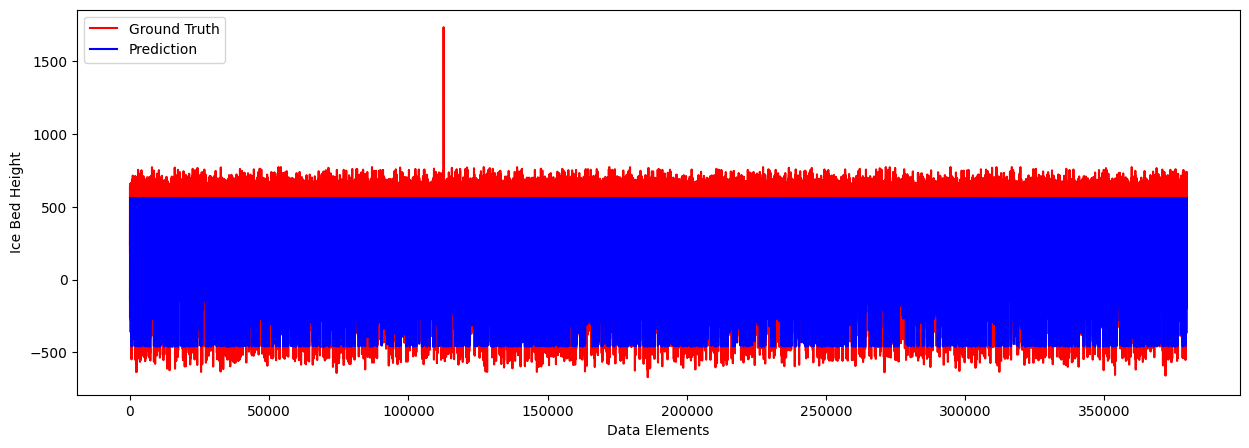

In [ ]:
plt.subplots(figsize=(15, 5))

plt.plot(data_train_Y_full_range, color='red', label="Ground Truth") # Y_test_given,y_pred_test
plt.plot(train_Predict_full_range, color='blue', label="Prediction")
plt.ylabel("Ice Bed Height")
plt.xlabel("Data Elements")
plt.legend(loc="upper left")
plt.show()

In [ ]:
y_predict_test = model.predict(data_test_X_lstm)

7909/7909 [==============================] - 24s 3ms/step


In [ ]:
y_test.shape, y_predict_test.shape

((253083, 1), (253083, 1))

In [ ]:
test_Predict_full_range = scaler_Y.inverse_transform(y_predict_test)
data_test_Y_full_range = scaler_Y.inverse_transform(y_test)

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

print('RMSE:',np.sqrt(mean_squared_error(data_test_Y_full_range, test_Predict_full_range)))
print('RMSE Percentage:',rmspe(data_test_Y_full_range, test_Predict_full_range))
print('RMSE Percentage-1:',rmspe_1(data_test_Y_full_range, test_Predict_full_range))
print('Mean Absolute Error:', mean_absolute_error(data_test_Y_full_range, test_Predict_full_range))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(data_test_Y_full_range, test_Predict_full_range))
print('R^2 Score:', r2_score(data_test_Y_full_range, test_Predict_full_range))

RMSE: 81.17395471303719
RMSE Percentage: 4631.98720351594
RMSE Percentage-1: 500.255332000948
Mean Absolute Error: 57.99306221317166
Mean Absolute Percentage Error: 0.9710576197106698
R^2 Score: 0.7968162263173291


In [ ]:
y_Predict_1201 = model.predict(data_1201_X_lstm)

45076/45076 [==============================] - 147s 3ms/step


In [ ]:
y_Predict_1201.shape

(1442401, 1)

In [ ]:
y_Predict_1201_full = scaler_Y.inverse_transform(y_Predict_1201)

In [ ]:
y_Predict_1201_full_flatten=y_Predict_1201_full.flatten()

In [ ]:
prediction_on_1201_2D=y_Predict_1201_full_flatten.reshape(1201,1201)
prediction_on_1201_2D.shape

(1201, 1201)

In [ ]:
import h5py

new_filename_2 = '/content/drive/MyDrive/REU 2023 Team 1: Ice Bed Topography Prediction/Research/Chen_Work/Old Models/Dense_LSTM_Vmag_Trial2.h5'

with h5py.File(new_filename_2, 'w') as hf:
    hf.create_dataset("track bed prediction",  data=prediction_on_1201_2D)

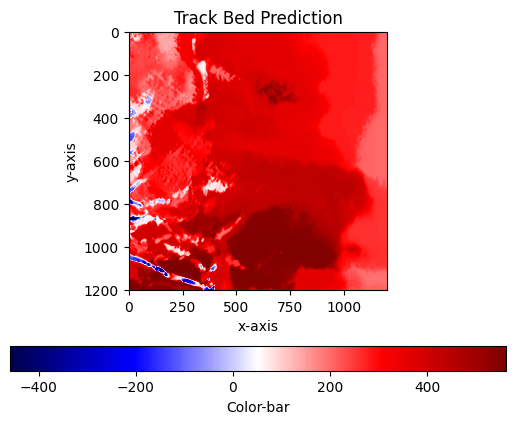

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(np.transpose(prediction_on_1201_2D), cmap="seismic")
#plt.imshow(a.squeeze(), cmap="seismic", interpolation="nearest") # new interpolated data
plt.title('Track Bed Prediction')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.colorbar(label="Color-bar", orientation="horizontal")